In [117]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [118]:
# Installing the relevant packages

!pip install pydub
!pip install noisereduce
!pip install json-tricks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
# Importing the relevant packages

import numpy as np
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

In [120]:
# Importing the model
saved_model_path = '/content/drive/MyDrive/data/modelLSTM.json'
saved_weights_path = '/content/drive/MyDrive/data/modelLSTM_weights.h5'

# Reading the model from JSON file
with open(saved_model_path, 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 400, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
# Emotion Definition

emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

In [170]:
# Defining the file path 
file_path = "/content/1001_DFA_NEU_XX.wav"

# Load file path
array, sr = librosa.core.load(file_path)

In [171]:
def preprocess(file_path, frame_length = 2048, hop_length = 512):
    '''
    A process to an audio .wav file before execcuting a prediction.
      Arguments:
      - file_path - The system path to the audio file.
      - frame_length - Length of the frame over which to compute the speech features. default: 2048
      - hop_length - Number of samples to advance for each frame. default: 512

      Return:
        'X_3D' variable, containing a shape of: (batch, timesteps, feature) for a single file (batch = 1).
    ''' 
    # Fetch sample rate.
    _, sr = librosa.load(path = file_path, sr = None)
    # Load audio file
    rawsound = AudioSegment.from_file(file_path, duration = None) 
    # Normalize to 5 dBFS 
    normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
    # Transform the audio file to np.array of samples
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32') 
    # Noise reduction                  
    final_x = nr.reduce_noise(normal_x, sr=sr)
        
        
    f1 = librosa.feature.rms(final_x, frame_length=frame_length, hop_length=hop_length, center=True, pad_mode='reflect').T # Energy - Root Mean Square
    f2 = librosa.feature.zero_crossing_rate(final_x, frame_length=frame_length, hop_length=hop_length,center=True).T # ZCR
    f3 = librosa.feature.mfcc(final_x, sr=sr, S=None, n_mfcc=13, hop_length = hop_length).T # MFCC   
    X = np.concatenate((f1, f2, f3), axis = 1)
    
    X_3D = np.expand_dims(X, axis=0)
    # print the shape of the preprocessed array
    print(X_3D.shape)
    data = X_3D

    # Reshape data to have 400 time steps
    new_time_steps = 400
    # create an empty array with the new shape
    data_reshaped = np.zeros((data.shape[0], new_time_steps, data.shape[2]))  
    # copy the original data into the new array
    data_reshaped[:, :data.shape[1], :] = data 
    # reshape the array to the final shape
    data_reshaped = data_reshaped.reshape((data.shape[0], new_time_steps, data.shape[2]))
    # print the shape of the reshaped array  
    print(data_reshaped.shape)
    
    return data_reshaped

In [172]:
# load the saved/trained weights
model.load_weights("/content/drive/MyDrive/data/modelLSTM_weights.h5")

# extract features and reshape it
# features = preprocess(file_path).reshape(1, -1)
features = preprocess(file_path)
predictions = model.predict(features, use_multiprocessing=True)

(1, 64, 15)
(1, 400, 15)
1/1 [==============================] - 0s 65ms/step


In [173]:
emotions = {
    0 : 'neutral',
    1 : 'calm',
    2 : 'happy',
    3 : 'sad',
    4 : 'angry',
    5 : 'fearful',
    6 : 'disgust',
    7 : 'suprised'   
}
emo_list = list(emotions.values())

def is_silent(data):
    # Returns 'True' if below the 'silent' threshold
    return max(data) < 100

1/1 [==============================] - 0s 57ms/step
[array([1.3586735e-02, 2.2260733e-02, 2.5524679e-04, 8.1628942e-01,
       1.9419484e-04, 1.7370190e-02, 1.1582026e-01, 1.4223183e-02],
      dtype=float32)]
[1.35867354e-02 2.22607329e-02 2.55246792e-04 8.16289425e-01
 1.94194843e-04 1.73701905e-02 1.15820259e-01 1.42231826e-02]


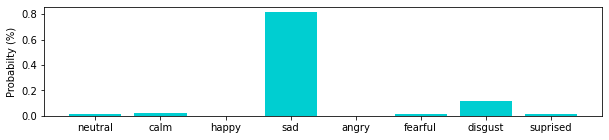

In [174]:
import matplotlib.pyplot as plt
total_predictions = []

# Model's prediction => an 8 emotion probabilities array.
predictions = model.predict(features, use_multiprocessing=True)
pred_list = list(predictions)
print(pred_list)

# Get rid of 'array' & 'dtype' statments.
pred_np = np.squeeze(np.array(pred_list).tolist()) 
print(pred_np)
    
# Present emotion distribution for a sequence (7.1 secs).
fig = plt.figure(figsize = (10, 2))
plt.bar(emo_list, pred_np, color = 'darkturquoise')
plt.ylabel("Probabilty (%)")
plt.show()

In [181]:
# print the emotion with the maximum probability
max_emo = np.argmax(predictions)
print('max emotion:', emotions.get(max_emo,-1))
    
print(100*'-')

max emotion: sad
----------------------------------------------------------------------------------------------------
